In [2]:
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# Some test functions

def fun0(x):
    return np.sin(10/(0.0001+x))
def fun1(x):
    return 1/np.sqrt(x)
def fun2(x):
    return 1/(x**(0.6))

# boundaries [a,b] = [0,1]
a = 0
b = 1
# tol is used for the termination criteria, 
# the ratio of the 
tol = 10**-10


tc [3.04341788 2.84706834 2.6507188  2.45436926 2.25801972 2.06167018
 1.86532064 1.6689711  1.47262156 1.27627202 1.07992247 0.88357293
 0.68722339 0.49087385 0.29452431 0.09817477]
xc [-0.99518473 -0.95694034 -0.88192126 -0.77301045 -0.63439328 -0.47139674
 -0.29028468 -0.09801714  0.09801714  0.29028468  0.47139674  0.63439328
  0.77301045  0.88192126  0.95694034  0.99518473]


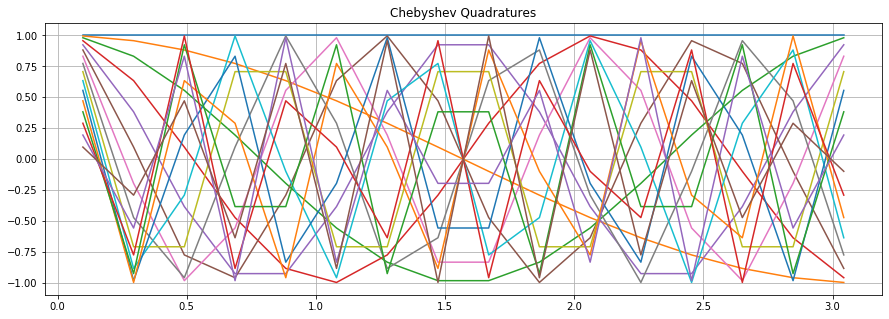

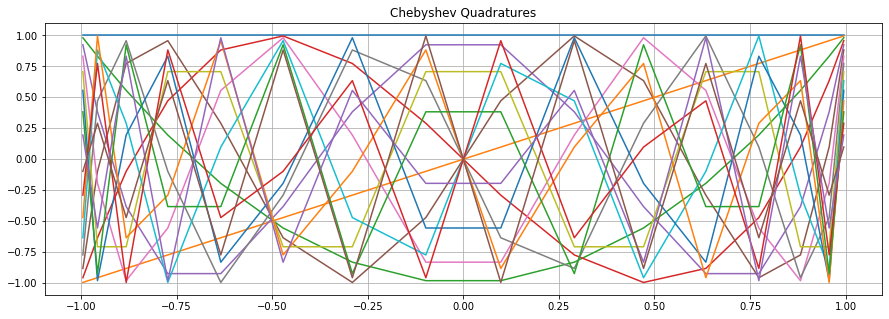

Condition number:  1.4142135623730974


In [4]:
# Chebyshev quads
nc = 16
nx = np.arange(1,nc+1) # python indexing
xc = np.cos((nx-1/2)*np.pi/nc)[::-1] # rescale and flip
uc = np.zeros((nc,nc)) # Chebyshevs over our nodes
tc = np.arccos(xc)
uc = np.cos((nx-1)*tc[:,None])
xc=xc.T # transpose
vc = np.linalg.inv(uc)
print("tc",tc)
print("xc",xc)
# take a look at what they look like:
plt.figure(figsize=(15,5))
plt.plot(tc,uc)
plt.grid()
plt.title("Chebyshev Quadratures")
plt.show()
plt.close()
plt.figure(figsize=(15,5))
plt.plot(xc,uc)
plt.grid()
plt.title("Chebyshev Quadratures")
plt.show()
plt.close()


# check the condition number:
print("Condition number: ",np.linalg.cond(uc))


In [5]:
# Jeremy's bounds:
maxlev = 1000
maxbox = 100000

# note that transposes may be more computationally efficient depending
# on the programming language! The choices here are for fortran, but is
# not optimal for Matlab!

ilevs = np.zeros((2,maxlev))
dints = np.zeros((2,maxbox))
itree = np.zeros((4,maxbox))
coefs = np.zeros((nc,maxbox))

icurr = 0
icbox = 1
# initialize first box [0,1]
ilevs[0,0] = 0
ilevs[1,0] = 0
dints[0,0] = a
dints[1,0] = b

# iterate through every level
for ilev in range(0,maxlev-1):
    if (ilevs[1,ilev] < ilevs[0,ilev]):
        break
    # initialize next level
    ilevs[0,ilev+1] = ilevs[1,ilev]+1
    ilevs[1,ilev+1] = ilevs[1,ilev]
    # iterate through the boxes at this level
    for ibox in range(int(ilevs[0,ilev]),int(ilevs[1,ilev])+1):
            # front and back of each box
            aa = dints[0,ibox]
            bb = dints[1,ibox]
            # compute function at level
            fs = fun2((xc+1)*(bb-aa)/2+aa) # embed change of interval
            # compute coefficients
            ccs = vc@fs
            max_coef = max(abs(ccs))
            # this is one particular termination criteria - it is L_infty and so in general
            # not terminate for singular functions. For L_2 discretizations, multiply the
            # left-hand side by sqrt(bb-aa)
            if (max(abs(ccs[-2::])))/max_coef < tol:
                # we're at a leaf!
                coefs[:,icurr] = ccs
                itree[3,ibox]=icurr
                itree[0,ibox]=0
                itree[1,ibox]=0
                icurr=icurr+1
            else:
                # create more boxes and iterate down
                ichild1 = int(ilevs[1,ilev+1]+1)
                ichild2 = int(ilevs[1,ilev+1]+2)
                abmid = (aa+bb)/2
                dints[0,ichild1] = aa
                dints[1,ichild1] = abmid
                dints[0,ichild2] = abmid
                dints[1,ichild2] = bb
                itree[0,ibox] = ichild1
                itree[1,ibox] = ichild2
                itree[2,ichild1] = ibox
                itree[2,ichild2] = ibox
                ilevs[1,ilev+1] = ilevs[1,ilev+1] + 2
                

In [10]:
# evaulate
x = 1e-14
ib = 0

for i in range(0,maxlev):
    if (itree[3,ib] != 0.0):
        # this is the box
        break
    else: 
        abmid =(dints[0,ib]+dints[1,ib])/2
        if (x >= abmid):
            ib = int(itree[1,ib])
        else:
            ib = int(itree[0,ib])
print(ib)   
#ib=94
print("dints: ", dints[:,ib])
print("itree:", itree[:,ib])

# what is this
a_rel = dints[0,ib]
b_rel = dints[1,ib]
x_rel = (x-a_rel)/(b_rel-a_rel)*2-1
coef_loc = coefs[:,int(itree[3,ib])]

print(a_rel)
print(b_rel)
print("x_rel:",x_rel)

94
dints:  [7.10542736e-15 1.42108547e-14]
itree: [ 0.  0. 91. 46.]
7.105427357601002e-15
1.4210854715202004e-14
x_rel: -0.18525023289344


In [11]:
# chebyshev expansion
val = 0
t = np.arccos(x_rel)
print(coef_loc)
for i in range(0,nc):
    val = val+coef_loc[i]*np.cos(i*t)
true_val = fun2(x)
err_disc = val - true_val
err_disc_rel = (err_disc)/true_val

[ 2.48666319e+08 -5.13808037e+07  7.06088559e+06 -1.05055880e+06
  1.62281143e+05 -2.56217637e+04  4.10363900e+03 -6.63926124e+02
  1.08227005e+02 -1.77449651e+01  2.92296493e+00 -4.83291626e-01
  8.01593973e-02 -1.33302473e-02  2.22013518e-03 -3.60667706e-04]


In [8]:
print(true_val)
print(val)
print(err_disc)
print(err_disc_rel)

251188643.15095782
251188643.15101933
6.151199340820312e-05
2.448836565084514e-13
